In [65]:
import warnings
warnings.filterwarnings("ignore")

In [129]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import statsmodels.api as sm
from arch.unitroot import ADF
import yfinance as yf

trans_cov = 1e-5 / (1 - 1e-5) * np.eye(2)
threshold = 1.96

def adfTest(series):
    adfT = ADF(series)
    if adfT.pvalue > 0.05:
        return False, adfT.pvalue
    return True, adfT.pvalue

def visualize(data, symbols):
    plt.figure(figsize=(15, 7))
    for syl in symbols:
        data[syl].plot(label=syl)
    plt.legend()
    plt.ylabel('Adjusted YTM')
    plt.show()
    print("Successfully Plot YTM")

def spread(X, Y):
    sp = Y - X
    print(sp)
    if not adfTest(sp)[0]:
        print("Spread is not stationary. P value of ADF test is", adfTest(sp)[1])
    else:
        print('''
            Spread is stationary
            P value of ADF test: %f
            ''' % (adfTest(spread)[1]))
    return sp
    
def cointegration(X, Y):
    results = sm.OLS(Y, sm.add_constant(X)).fit()
    resid = results.resid
    if not adfTest(resid)[0]:
        print("X and Y are not cointegrated. P value of ADF test is", adfTest(resid)[1])
        return None
    else:
        print('''
        X and Y are cointegrated
        P value of ADF test: %f
        Intercept: %f
        Beta: %f
        ''' % (adfTest(resid)[1], results.params[0], results.params[1]))
        return results.params[0], results.params[1]

def kalman_filter(data, symbols, trans_cov):
    obs_mat = sm.add_constant(data[symbols[0]].values, prepend=False)[:, np.newaxis]

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                      initial_state_mean=np.ones(2),
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=0.5,
                      transition_covariance=trans_cov)
    state_means, state_covs = kf.filter(data[symbols[1]].values)
    slope=state_means[:, 0]
    intercept=state_means[:, 1]
    plt.figure(figsize =(15,7))
    plt.plot(data[symbols[1]].index, slope, c='b')
    plt.ylabel('slope')
    plt.title('kf updating slope')
    
    plt.figure(figsize =(15,7))
    plt.plot(data[symbols[1]].index,intercept,c='r')
    plt.ylabel('intercept')
    plt.title('kf updating intercept')
    plt.show()

    kl_spread = data[symbols[1]] - data[symbols[0]] * state_means[:, 0] - state_means[:, 1]
    return kl_spread, slope

def set_signal(data, threshold, symbols):
    fig, ax = plt.subplots(2, 1, figsize=(15, 8))
    df = pd.DataFrame()
    count = 0
    titles = ["Fixed Beta", "Kalman Filter"]

    for sym in symbols:
        mean, lower, upper, buy, sell, close_pos = "mean_"+sym, "lower_"+sym, "upper_"+sym, "buy_"+sym, "sell_"+sym, "close_pos_"+sym

        df['spread'] = data[sym]
        df[mean] = df['spread'].mean()
        mu = df[mean]
        sigma = df['spread'].std()
        df[upper] = mu + threshold * sigma
        df[lower] = mu - threshold * sigma

        df[buy] = df['spread'][((df['spread'] < df[lower]) & (df['spread'].shift(1) >= df[lower])) | 
                                ((df['spread'] < df[upper]) & (df['spread'].shift(1) >= df[upper]))]
        # df[close_pos] = df['spread'][((df['spread'] > lower) & (df['spread'].shift(1) <= lower)) | 
        #                             ((df['spread'] < upper) & (df['spread'].shift(1) >= upper))]
        df[sell] = df['spread'][((df['spread'] > df[upper]) & (df['spread'].shift(1) <= df[upper])) |
                                ((df['spread'] > df[lower]) & (df['spread'].shift(1) <= df[lower]))]

        pic = ax[count]
        pic.plot(df['spread'], 'g')
        pic.plot(df[mean],'--r', label=mean)
        pic.plot(df[upper], '--b', label=upper)
        pic.plot(df[lower], '--b', label=lower)
        pic.plot(df[buy], 'm^', label=buy)
        pic.plot(df[sell], 'cv', label=sell)

        pic.set_title(titles[count])
        pic.set_xlabel('Time')
        pic.set_ylabel('YTM' + titles[count])
        pic.legend()

        count+=1

    return df
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

    

    print("Success!")

                                 AAPL        MSFT
Date                                             
2019-10-01 00:00:00-04:00   54.330791  130.922409
2019-10-02 00:00:00-04:00   52.968834  128.610916
2019-10-03 00:00:00-04:00   53.418789  130.167816
2019-10-04 00:00:00-04:00   54.916222  131.925308
2019-10-07 00:00:00-04:00   54.928314  130.970200
...                               ...         ...
2023-09-25 00:00:00-04:00  175.183563  315.174316
2023-09-26 00:00:00-04:00  171.084549  309.814514
2023-09-27 00:00:00-04:00  169.562302  310.459686
2023-09-28 00:00:00-04:00  169.821014  311.303375
2023-09-29 00:00:00-04:00  170.338364  313.397583

[1007 rows x 2 columns]


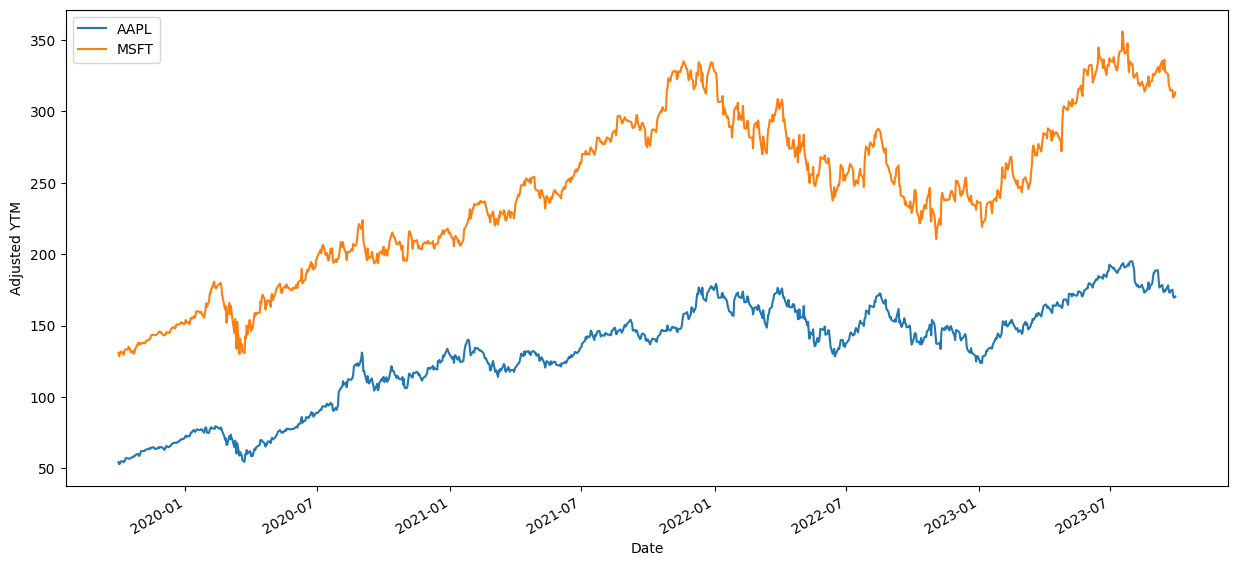

Successfully Plot YTM


In [109]:
AAPL = yf.Ticker("AAPL")
MSFT = yf.Ticker("MSFT")
hist = pd.DataFrame()
start_date = "2019-10-01"
end_date = "2023-10-01"
hist['AAPL'] = pd.DataFrame(AAPL.history(start=start_date, end=end_date)['Close'])
hist['MSFT'] = pd.DataFrame(MSFT.history(start=start_date, end=end_date)['Close'])
hist.dropna(axis = 0, inplace = True)
print(hist)
syms = ['AAPL', 'MSFT']
visualize(hist, syms)


Date
2019-10-01 00:00:00-04:00     76.591618
2019-10-02 00:00:00-04:00     75.642082
2019-10-03 00:00:00-04:00     76.749027
2019-10-04 00:00:00-04:00     77.009087
2019-10-07 00:00:00-04:00     76.041885
                                ...    
2023-09-25 00:00:00-04:00    139.990753
2023-09-26 00:00:00-04:00    138.729965
2023-09-27 00:00:00-04:00    140.897385
2023-09-28 00:00:00-04:00    141.482361
2023-09-29 00:00:00-04:00    143.059219
Length: 1007, dtype: float64
Spread is not stationary. P value of ADF test is 0.47005906195620084


<Axes: xlabel='Date'>

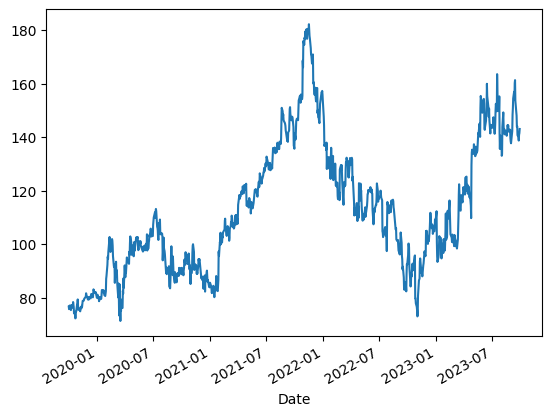

In [111]:
sp = spread(hist['AAPL'], hist['MSFT'])
sp.plot()

In [113]:
params = cointegration(hist['AAPL'], hist['MSFT'])
intercept = 0
beta = 0
if params is not None:
    intercept = params[0]
    beta = params[1]
res = pd.DataFrame()
coin_spread = hist['MSFT'] - intercept - beta*hist['AAPL']

X and Y are not cointegrated. P value of ADF test is 0.24125999792843922


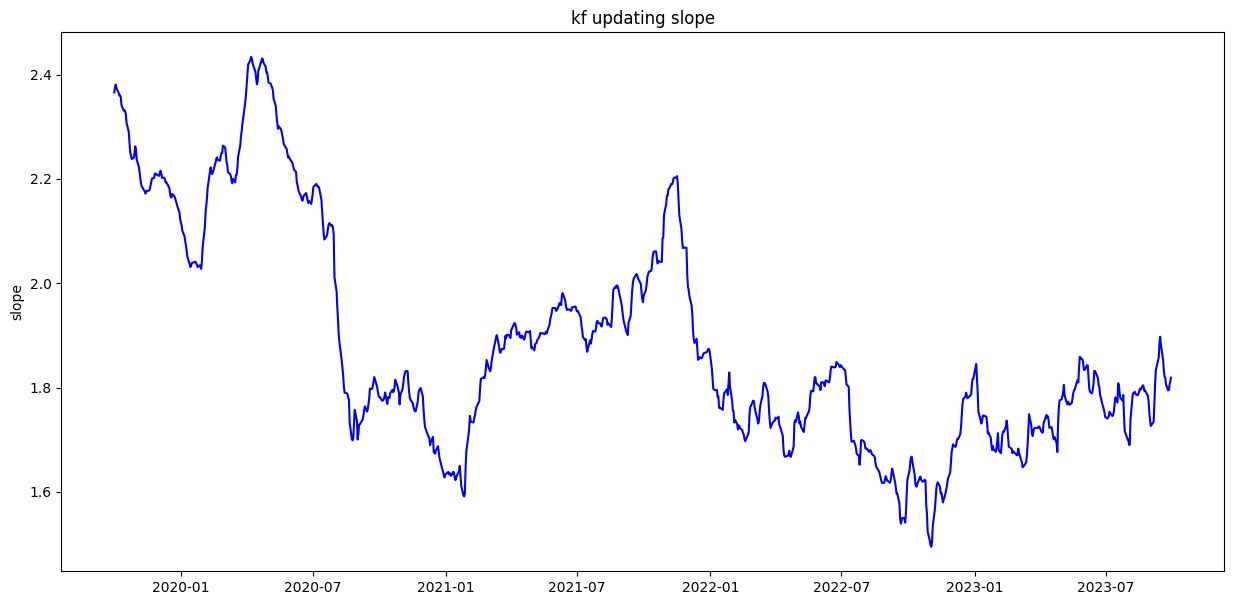

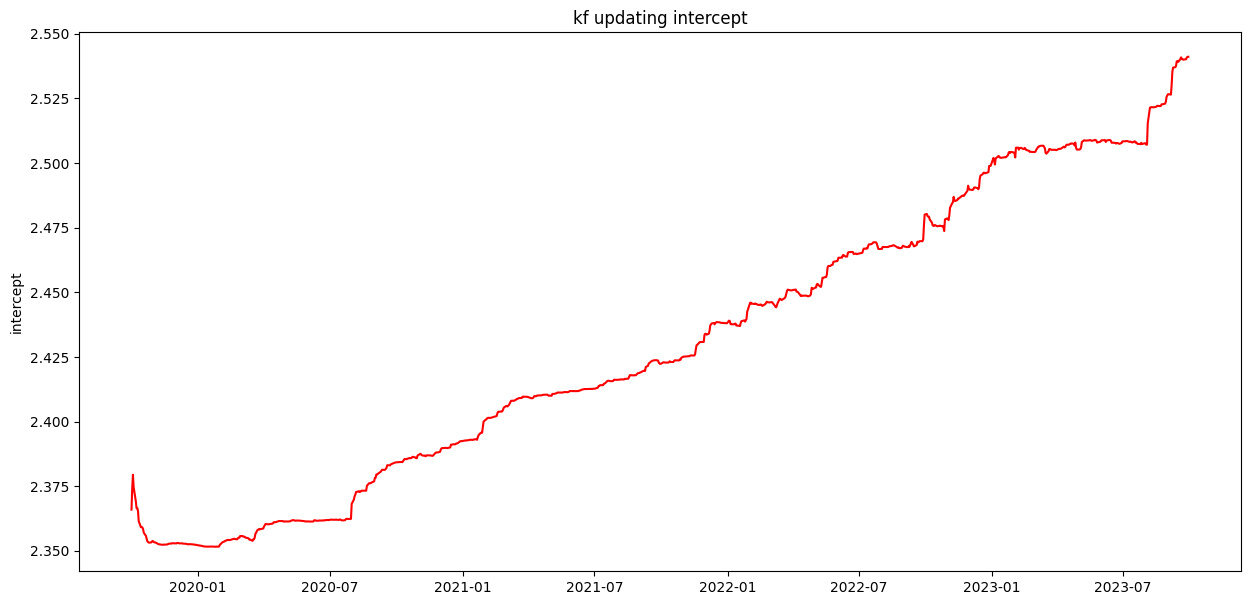

In [139]:
kf_spread, kf_beta = kalman_filter(hist, syms, trans_cov)

In [141]:
result = adfTest(kf_spread)
print(result)

(True, 5.4355313400006665e-11)


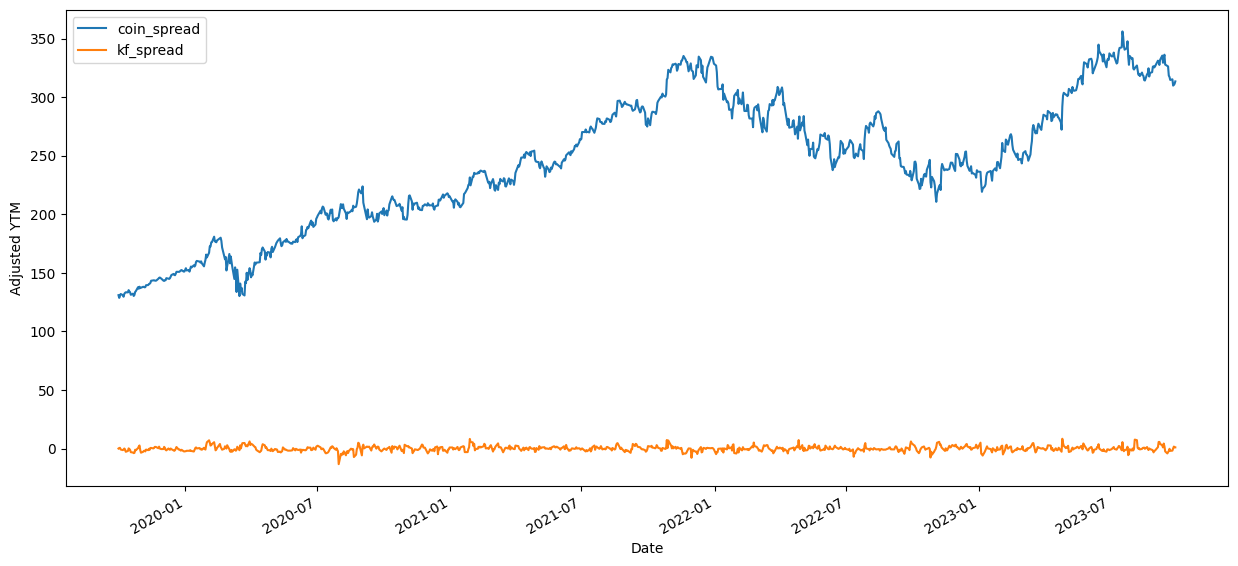

Successfully Plot YTM


In [143]:
res['coin_spread'], res['kf_spread'] = coin_spread, kf_spread
spread_syms = ["coin_spread", "kf_spread"]
visualize(res, spread_syms)

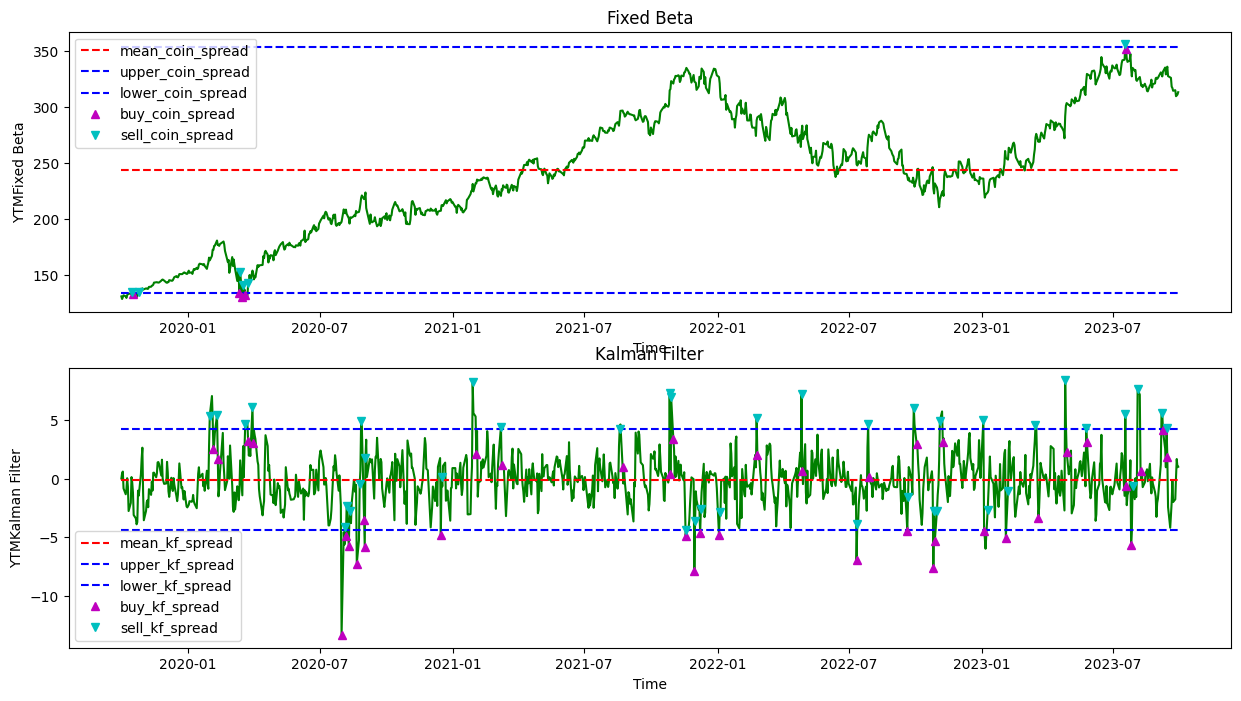

In [145]:
df = set_signal(res, threshold, spread_syms)

In [147]:
df = df.fillna(1000)
df.head()

,spread,mean_coin_spread,upper_coin_spread,lower_coin_spread,buy_coin_spread,sell_coin_spread,mean_kf_spread,upper_kf_spread,lower_kf_spread,buy_kf_spread,sell_kf_spread
Date,,,,,,,,,,,
2019-10-01 00:00:00-04:00,0.012344,243.706257,353.667602,133.744912,1000.0,1000.0,-0.078056,4.198525,-4.354636,1000.0,1000.0
2019-10-02 00:00:00-04:00,0.459898,243.706257,353.667602,133.744912,1000.0,1000.0,-0.078056,4.198525,-4.354636,1000.0,1000.0
2019-10-03 00:00:00-04:00,0.605077,243.706257,353.667602,133.744912,1000.0,1000.0,-0.078056,4.198525,-4.354636,1000.0,1000.0
2019-10-04 00:00:00-04:00,-0.833674,243.706257,353.667602,133.744912,1000.0,1000.0,-0.078056,4.198525,-4.354636,1000.0,1000.0
2019-10-07 00:00:00-04:00,-1.329271,243.706257,353.667602,133.744912,1000.0,1000.0,-0.078056,4.198525,-4.354636,1000.0,1000.0


# Spread Cointegration Type of Signals (Not working for not passing stationarity test)
## See {Kalman Filter} section below for reliable results

In [167]:
# Buy Spread: the signal says spread is undervalued (or return to normal band from being overvalued)
                        # so long the expensive (MSFT) and short the cheap (AAPL)
# Sell Spread: the signal says spread is overvalued (or return to normal band from being undervalued)
                        # so short the expensive (MSFT) and long the cheap (AAPL)
NAA = 1000.0
coin_spread_signals = df[["buy_coin_spread", "sell_coin_spread"]]
cs_MSFT = np.zeros(len(coin_spread_signals))
# cs_sell_MSFT = np.zeros(len(coin_spread_signals))
# cs_buy_AAPL = np.zeros(len(coin_spread_signals))
# cs_sell_AAPL = np.zeros(len(coin_spread_signals))
for t in coin_spread_signals.index:
    b = df.loc[t]["buy_coin_spread"]
    s = df.loc[t]["sell_coin_spread"]
    if (b != NAA) & (s == NAA):
        cs_MSFT[list(coin_spread_signals.index).index(t)] = 1
    if (b == NAA) & (s != NAA):
        cs_MSFT[list(coin_spread_signals.index).index(t)] = -1
cs_AAPL = cs_MSFT * (-1)

In [168]:
coin_spread_signals['cs_MSFT'] = cs_MSFT
coin_spread_signals['cs_AAPL'] = cs_AAPL

In [173]:
coin_spread_signals[coin_spread_signals["cs_MSFT"] != 0]

,buy_coin_spread,sell_coin_spread,cs_30,cs_10
Date,,,,
1979-10-19 00:00:00-05:00,-0.547107,1000.000000,1.0,-1.0
1979-10-26 00:00:00-05:00,1000.000000,-0.488007,-1.0,1.0
1986-05-16 00:00:00-05:00,-0.529443,1000.000000,1.0,-1.0
1986-05-19 00:00:00-05:00,1000.000000,-0.480344,-1.0,1.0
1986-05-22 00:00:00-05:00,-0.569353,1000.000000,1.0,-1.0
...,...,...,...,...
2023-02-08 00:00:00-06:00,1000.000000,-0.513155,-1.0,1.0
2023-02-22 00:00:00-06:00,-0.540831,1000.000000,1.0,-1.0
2023-03-13 00:00:00-05:00,1000.000000,-0.431588,-1.0,1.0


In [175]:
coin_spread_signals['raw_MSFT'] = hist['MSFT']
coin_spread_signals['raw_AAPL'] = hist['AAPL']
coin_spread_signals

,buy_coin_spread,sell_coin_spread,cs_30,cs_10,raw_30,raw_10
Date,,,,,,
1977-02-15 00:00:00-06:00,1000.0,1000.0,0.0,-0.0,7.700,7.360
1977-02-16 00:00:00-06:00,1000.0,1000.0,0.0,-0.0,7.670,7.340
1977-02-17 00:00:00-06:00,1000.0,1000.0,0.0,-0.0,7.670,7.260
1977-02-18 00:00:00-06:00,1000.0,1000.0,0.0,-0.0,7.760,7.410
1977-02-22 00:00:00-06:00,1000.0,1000.0,0.0,-0.0,7.770,7.420
...,...,...,...,...,...,...
2024-09-24 00:00:00-05:00,1000.0,1000.0,0.0,-0.0,4.089,3.736
2024-09-25 00:00:00-05:00,1000.0,1000.0,0.0,-0.0,4.134,3.781
2024-09-26 00:00:00-05:00,1000.0,1000.0,0.0,-0.0,4.124,3.791


In [159]:
hist['AAPL']

Date
1977-02-15 00:00:00-06:00    7.360
1977-02-16 00:00:00-06:00    7.340
1977-02-17 00:00:00-06:00    7.260
1977-02-18 00:00:00-06:00    7.410
1977-02-22 00:00:00-06:00    7.420
                             ...  
2024-09-24 00:00:00-05:00    3.736
2024-09-25 00:00:00-05:00    3.781
2024-09-26 00:00:00-05:00    3.791
2024-09-27 00:00:00-05:00    3.749
2024-09-30 00:00:00-05:00    3.802
Name: tnx, Length: 11931, dtype: float64

# Kalman Filter Version of Signals

In [159]:
# Buy Spread: the signal says spread is undervalued (or return to normal band from being overvalued)
                        # so long the expensive (MSFT) and short the cheap (AAPL)
# Sell Spread: the signal says spread is overvalued (or return to normal band from being undervalued)
                        # so short the expensive (MSFT) and long the cheap (AAPL)
NAA = 1000.0
kf_signals = df[["buy_kf_spread", "sell_kf_spread"]]
kf_MSFT = np.zeros(len(kf_signals))
# cs_sell_MSFT = np.zeros(len(coin_spread_signals))
# cs_buy_AAPL = np.zeros(len(coin_spread_signals))
# cs_sell_AAPL = np.zeros(len(coin_spread_signals))
for t in kf_signals.index:
    b = df.loc[t]["buy_kf_spread"]
    s = df.loc[t]["sell_kf_spread"]
    if (b != NAA) & (s == NAA):
        kf_MSFT[list(kf_signals.index).index(t)] = 1
    if (b == NAA) & (s != NAA):
        kf_MSFT[list(kf_signals.index).index(t)] = -1
kf_AAPL = kf_MSFT * (-1)
kf_signals['kf_MSFT'] = kf_MSFT
kf_signals['kf_AAPL'] = kf_AAPL
kf_signals['raw_MSFT_kf'] = hist['MSFT']
kf_signals['raw_AAPL_kf'] = hist['AAPL']
kf_signals['beta'] = kf_beta

In [160]:
kf_signals

,buy_kf_spread,sell_kf_spread,kf_MSFT,kf_AAPL,raw_MSFT_kf,raw_AAPL_kf,beta
Date,,,,,,,
2019-10-01 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,130.922409,54.330791,2.365953
2019-10-02 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,128.610916,52.968834,2.374546
2019-10-03 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,130.167816,53.418789,2.380872
2019-10-04 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,131.925308,54.916222,2.374242
2019-10-07 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,130.970200,54.928314,2.365452
...,...,...,...,...,...,...,...
2023-09-25 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,315.174316,175.183563,1.794641
2023-09-26 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,309.814514,171.084549,1.795371
2023-09-27 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,310.459686,169.562302,1.806103


In [212]:
positions_AAPL = []
positions_MSFT = []

for i, row in kf_signals.iterrows():
    price_AAPL = row['raw_AAPL_kf']
    price_MSFT = row['raw_MSFT_kf']
    
    signal_AAPL = row['kf_AAPL']  # +1 for buy, -1 for sell, 0 for hold
    signal_MSFT = row['kf_MSFT']  
    
    beta = row['beta']
    
    # Define positions based on the beta
    if signal_MSFT != 0:
        position_MSFT = signal_MSFT * 100 # Assume we take 100 units of MSFT for each trade
        # Calculate the hedged position in Stock B using beta
        position_AAPL = -position_MSFT * beta  
        
    else:
        # If no trade signal, no position is taken
        position_AAPL = 0
        position_MSFT = 0
    
    positions_AAPL.append(position_AAPL)
    positions_MSFT.append(position_MSFT)

kf_signals['position_AAPL'] = positions_AAPL
kf_signals['position_MSFT'] = positions_MSFT

kf_signals

,buy_kf_spread,sell_kf_spread,kf_MSFT,kf_AAPL,raw_MSFT_kf,raw_AAPL_kf,beta,position_APPL,position_MSFT,position_AAPL
Date,,,,,,,,,,
2019-10-01 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,130.922409,54.330791,2.365953,0,0.0,0.0
2019-10-02 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,128.610916,52.968834,2.374546,0,0.0,0.0
2019-10-03 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,130.167816,53.418789,2.380872,0,0.0,0.0
2019-10-04 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,131.925308,54.916222,2.374242,0,0.0,0.0
2019-10-07 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,130.970200,54.928314,2.365452,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-09-25 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,315.174316,175.183563,1.794641,0,0.0,0.0
2023-09-26 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,309.814514,171.084549,1.795371,0,0.0,0.0
2023-09-27 00:00:00-04:00,1000.0,1000.0,0.0,-0.0,310.459686,169.562302,1.806103,0,0.0,0.0


<Axes: xlabel='Date'>

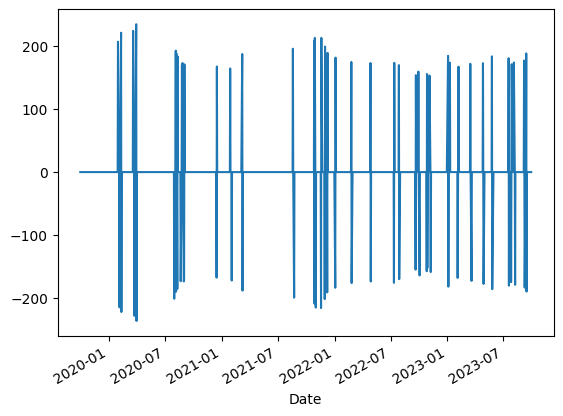

In [214]:
kf_signals['position_AAPL'].plot()

In [216]:
AAPL_cost = kf_signals['position_AAPL'] * kf_signals['raw_AAPL_kf'] * (-1)
MSFT_cost = kf_signals['position_MSFT'] * kf_signals['raw_MSFT_kf'] * (-1)
tot_profit = AAPL_cost.sum() + MSFT_cost.sum()
print("Total Profit: ", tot_profit)

Total Profit:  16815.51153225672


In [187]:
coin_spread_signals.to_csv("cs_signals.csv", index=False)
kf_signals.to_csv("kf_signals.csv", index=False)

In [218]:
# Buy and Hold
tot_b_h = 100 * ((kf_signals['raw_MSFT_kf'][-1] - kf_signals['raw_MSFT_kf'][0]) + (kf_signals['raw_AAPL_kf'][-1] - kf_signals['raw_AAPL_kf'][0]))
print("Buy-and-hold Profit: ", tot_b_h)

Buy-and-hold Profit:  29848.274612426758


### The pair trading certainly makes less profits than the simple buy-and-hold. However, this is fair enough as we cancel out risks by setting dynamic hedge ratio between AAPL and MSFT, and make quite amount of profits!